# CT reconstruction via spectral decomposition of the atomic structure

First we load the atomic structure and the MD trajectory in order to generate the synthetic dataset.
For the atomic model in each frame we select the C-$\alpha$ positions.

In [1]:
import torch
import numpy as np
import mdtraj as md

import matplotlib.pyplot as plt



## We load an MD trajectory.
## The molecular structure must be in a pdb or psf file.
## The trajectory is stored in a dcd file.

struct = 2 # 1 for the small protein (214 C-alpha atoms) and 2 for the big one (590 C-alpha atoms).

if struct == 1:
    MD_traj = md.load('data/struct1/dims0001_fit-core.dcd',top = 'data/struct1/adk4ake.psf')
if struct == 2:
    MD_traj = md.load('data/struct2/MD_traj2_short.dcd',top = 'data/struct2/DESRES-Trajectory_sarscov2-12212688-5-2-no-water.pdb')


## Here we select the C-alpha positions
indices = []
for m in MD_traj.topology.atoms_by_name('CA'):
    indices.append(m.index)

# We have to multily the trajectory by 10 so that the interatomic distance is in Angstroms
CA_pos = torch.tensor(MD_traj.xyz[:,indices,:])*10 
print('Average interatomic distance:',round(float((CA_pos[:,1:]-CA_pos[:,:-1]).norm(dim=-1).mean()),2), 'Angstroms')

Average interatomic distance: 3.85 Angstroms


## Parameters of the MD trajectory

Now we compute the parameters of each atomic model in the MD trajectory (rotation angles, orientation and location).
This will serve as ground truth.

In [2]:
## We set the reference atom. In this case, we select the atom which is most
# centred in the structure.

D = torch.zeros(CA_pos.shape[1])

for i in range(CA_pos.shape[1]):
    D[i] = (CA_pos[0] - CA_pos[0,i]).sum(dim=0).norm()

ref_idx = torch.argmin(D)

## We now compute the parameters for each of the chains in the MD trajectory
## These parameters represent the groud truth.

from tools.DFF import compute_parameters

Psi, Theta, x0s, Orientations, Dists = compute_parameters(CA_pos, ref_idx)

from data_generator.structure_batch import chain_structure

# We create a chain structure for the MD trajectory. This one will be used to generate the synthetic dataset.
trajectory_ground_truth = chain_structure(Psi, Theta, x0s, Orientations, Dists, ref_idx)

## We select the indexes that are to be estimated (those which may vary depending on the conformation).
## Since we do not have prior information about secondary structures, we select all the angles.
idx_model = list(range(Psi.shape[1]))

### Synthetic cryo-EM data

We generate the synthetic cryo-EM dataset. We need to specify the features of the dataset such as the CTF parameters and noise levels.

For each cryo-EM image, the defocus of the CTF is chosen at random among the values in the vector 'Df'.

$$
CTF(k, \lambda, \Delta f, C_s) = -\sin \left( \pi \lambda |k|^2 \Delta f - \dfrac{\pi \lambda^3 |k|^4 C_s}{2} + \alpha \right) \exp (-B|k|) 
\quad \text{for} \ k \in \left\{ \left(\frac{i}{L},\frac{j}{L}\right), \ (i,j) \in [0, 1, n_{px}-1]  \right\} 
$$
where $\Delta f$ is the defocus in Angstroms, i.e. $2.5\cdot 10^4$, $L$ is the length of the image side in Angstroms and $n_{px}$ is the number of pixels of the image side.

The wavelength $\lambda$ in terms of the voltage $V$ in KeV:
$$
\lambda = \dfrac{h}{\sqrt{2 m_0 E \left( 1+ \frac{E}{2m_0 c^2}\right)}} = \dfrac{12.2643247}{\sqrt{V\cdot 10^3 + 0.978466V^2}}.
$$ 

/home/ce423/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 4000/4000 [01:17<00:00, 51.42it/s]


CTF filters


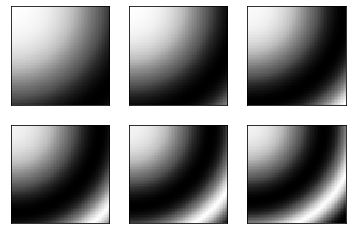

In [3]:
### Here we generate the dataset

from data_generator.dataset import dataset

CTF_data_feat = {
        'kV' : 200, # voltage in KV
        'Df' : torch.tensor([1.5, 2., 2.5, 3., 3.5, 4.]), # List of Defocus values in microns
        'Cs' : 0., # Spherical aberration
        'alpha' : 0.1, # Phase shift
        'env_dec' : 0. # Decay factor
        }

dataset_features = {
        'struct' : trajectory_ground_truth, # The atomic models computed above
        'n_imgs' : 4000, # Number of cryo-EM images
        'orient_variability' : torch.Tensor([[0,2*np.pi], 
                                             [0,2*np.pi], 
                                             [0,2*np.pi]]), # Range of orientations in the dataset
        'n_px_3d' : 16,
        'sigma_gaussian_3d' : 3.,
        'mask_size_3d' : 5,
        'noise_3d' : .5,
        
        'n_px_2d' : 64,
        'noise_2d' : 10.,
        'density_type': 'Gaussian',
        'sigma_density' : 3.,
        
        'CTF_data_feat' : CTF_data_feat
        }


vols_data, structure_data, orientation_diffs_data, CT_images_noise, CT_images_clean, clean_imgs_no_CTF, img_lims, Df = dataset(dataset_features)

# Let's plot the CTF filters
from tools.CTF import CTF_filters

img_side = img_lims[0]-img_lims[1]

filters = CTF_filters(dataset_features['n_px_2d'], CTF_data_feat['kV'], CTF_data_feat['Df'], CTF_data_feat['Cs'], 
                      CTF_data_feat['alpha'], CTF_data_feat['env_dec'], img_side)

fig, axs = plt.subplots(int(filters.shape[0]/3)+(filters.shape[0]%3>0), 3)
for i in range(filters.shape[0]):
    axs[int(i/3), i%3].imshow(filters[i], cmap = 'Greys')
    axs[int(i/3), i%3].axes.get_xaxis().set_visible(False)
    axs[int(i/3), i%3].axes.get_yaxis().set_visible(False)

for j in range(i%3+1, 3):
    axs[int(i/3), j%3].imshow(filters[0]*0, cmap = 'Greys')
    axs[int(i/3), j%3].axes.get_xaxis().set_visible(False)
    axs[int(i/3), j%3].axes.get_yaxis().set_visible(False)

print('CTF filters')
plt.show()


### Examples of synthetic cryo-EM images

First row after applying the X-ray transform to the particle.
Second row after convolving with the CTF
Third row after adding gaussian noise

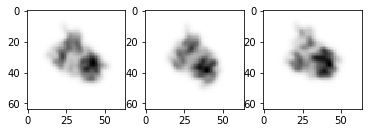

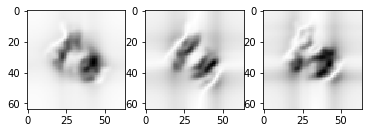

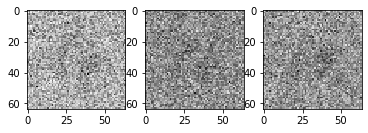

Signal to noise ratio: 0.04151029512286186


In [4]:
# Let's display some images
fig, axs = plt.subplots(1, 3)
axs[0].imshow(clean_imgs_no_CTF[0].transpose(0,1).flip(0,), cmap='Greys')
axs[1].imshow(clean_imgs_no_CTF[1].transpose(0,1).flip(0,), cmap='Greys')
axs[2].imshow(clean_imgs_no_CTF[2].transpose(0,1).flip(0,), cmap='Greys')
plt.show()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(CT_images_clean[0].transpose(0,1).flip(0,), cmap='Greys')
axs[1].imshow(CT_images_clean[1].transpose(0,1).flip(0,), cmap='Greys')
axs[2].imshow(CT_images_clean[2].transpose(0,1).flip(0,), cmap='Greys')
plt.show()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(CT_images_noise[0].transpose(0,1).flip(0,), cmap='Greys')
axs[1].imshow(CT_images_noise[1].transpose(0,1).flip(0,), cmap='Greys')
axs[2].imshow(CT_images_noise[2].transpose(0,1).flip(0,), cmap='Greys')
plt.show()

## Signal to Noise Ratio (SNR)
print('Signal to noise ratio:', float(CT_images_clean.var()/dataset_features['noise_2d']**2))

## Construct the model

Here we construct the model to make the predictions. We need to select the given conformation, which will be used as initialization, the number of eigenvectors in the spectral decomposition. We also need to specify the features of the images such as dimensions and CTF parameters.

In [5]:
# As given conformation we take the first structure in the MD trajectory
n_init = 0 
Psi_init = trajectory_ground_truth.Psi[n_init]
Theta_init = trajectory_ground_truth.Theta[n_init]
ref_idx = trajectory_ground_truth.ref_idx

# The interatomic distance is set to be constant 
# and equal to the average interatomic distance
# in the given conformation.
dists = trajectory_ground_truth.dists[n_init]
dists = dists*0 + dists.mean()

# We specify the number of eigenvectors for the spectral decomposition.
n_eigenval = 10

model_features = {
        'n_eigenval' : n_eigenval,
        
        # Given atomic model
        'Psi_init' : Psi_init,
        'Theta_init' : Theta_init,
        'dists' : dists,
        'ref_idx': ref_idx,
        
        # Features of the images
        'img_lims': img_lims, 
        'n_px': CT_images_noise.shape[-1],
        'sigma_density' : dataset_features['sigma_density'], # sigma of the Gaussian density for each atom
        'density_type' : dataset_features['density_type'],        
        'CTF_feat' : CTF_data_feat,
        
        # List of indexes to be estimated
        'param_idxs' : idx_model
        
        }

from model.model_chain import model_chain

model = model_chain(model_features)

## Graph Laplacian

Time to compute the graph Laplacian: 8.13911771774292
Time to compute the eigenvectors: 42.95172667503357


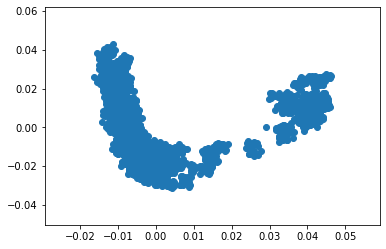

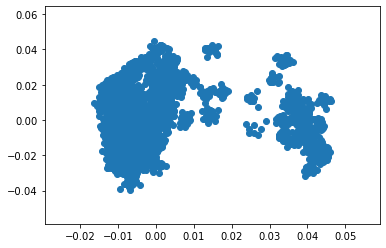

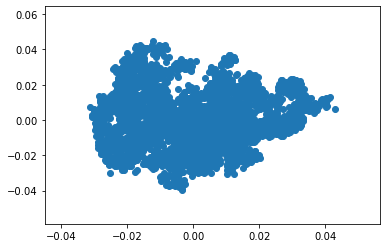

In [6]:
from time import time
from tools.graph import graph_gaussian_kernel, laplacian, eigen_graph

sigma_gauss_kernel = 5*dataset_features['n_px_3d']*dataset_features['noise_3d']

start = time()
graph = graph_gaussian_kernel(vols_data, sigma_gauss_kernel).detach()
print('Time to compute the graph Laplacian:', time() - start)

start = time()
Lap = laplacian(graph, True)
[eigen_val, eigen_vec] = eigen_graph(Lap, n_eigenval)
print('Time to compute the eigenvectors:', time() - start)

plt.scatter(eigen_vec[:,1], eigen_vec[:,2])
plt.show()
plt.scatter(eigen_vec[:,1], eigen_vec[:,3])
plt.show()
plt.scatter(eigen_vec[:,2], eigen_vec[:,3])
plt.show()

## Training and test data

Here we split the cryo-EM dataset into training and test data,

In [7]:
from tools.training import Dataset, train_model

# The orientation of the particles in the images are the sum of the 
# orientation of the particle in the MD trajectory plus the rotation
# applied when generating the cryo-EM dataset.
# This information is assumed to be known.

orientations = structure_data.orientation + orientation_diffs_data

# The inputs for the model are the following, which we concatenate in a single tensor: 
# -the eigenvector coordinates of each particle
# -the orientation of each particle
# -the location of each particle
# -the defocus of each image

inputs = torch.cat([eigen_vec, orientations, structure_data.x0, Df.unsqueeze(-1)], dim = -1)


train_pctg = .9
n_total = inputs.shape[0]
n_train = int(train_pctg*n_total)
n_test = n_total - n_train 
train_idx, test_idx = torch.utils.data.random_split(range(n_total), [n_train, n_test])

# We select the training data, i.e. the cryo-EM images with the corresponding inputs
train_inputs = inputs[train_idx]
training_data = Dataset(train_inputs, CT_images_noise[train_idx])


# We select the test data, i.e. the cryo-EM images with the corresponding inputs
# We also compute the atomic model for each particle, that are used to evaluate the accuracy of the predictions.
BB_test = structure_data.discrete_curves(orientation_diffs_data)[test_idx]
test_inputs = inputs[test_idx]

test_data_pointcloud = Dataset(test_inputs, BB_test)
test_data = Dataset(test_inputs, CT_images_clean[test_idx])


# Here we compute the CT images (without CTF) and the atomic models before training the model
# These will be used at the end to compare with the predictions after training.
preds_init = model.pred_images_without_CTF(test_inputs[:20, :-1]).detach()
BB_init = model.forward_disc_curve(test_inputs[:20]).detach()

###  Apply SGD to estimate the coefficients

This make take several minutes.

In [8]:
### Training

# Generators
training_params = {'batch_size': 100,
          'shuffle': True,
          'max_epochs' : 30,
          'learning_rate' : .1,
          'momentum': .9}

train_model(model, training_data, test_data, test_data_pointcloud, training_params)

Initial test loss: 1.108245849609375
Initial test average point cloud error: 7.661211967468262
Initial test average max point cloud error: 37.263057708740234
Initial test max point cloud error: 51.866451263427734


  0%|          | 0/36 [00:00<?, ?it/s]/home/ce423/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 36/36 [02:46<00:00,  4.62s/it]


Epoch 1 completed.
Training loss: 100.8418214586046
Test loss: 0.7457477450370789
Test average point cloud error: 6.034740924835205
Test average max point cloud error: 35.58014678955078
Test  max point cloud error: 48.45258712768555


100%|██████████| 36/36 [02:42<00:00,  4.51s/it]


Epoch 2 completed.
Training loss: 100.69255998399522
Test loss: 0.6831343173980713
Test average point cloud error: 5.684230804443359
Test average max point cloud error: 31.85488510131836
Test  max point cloud error: 44.7644157409668


100%|██████████| 36/36 [02:41<00:00,  4.50s/it]


Epoch 3 completed.
Training loss: 100.63872506883409
Test loss: 0.6446032524108887
Test average point cloud error: 5.4611968994140625
Test average max point cloud error: 29.8137149810791
Test  max point cloud error: 42.59196472167969


100%|██████████| 36/36 [02:47<00:00,  4.66s/it]


Epoch 4 completed.
Training loss: 100.60417599148221
Test loss: 0.6161074638366699
Test average point cloud error: 5.303267002105713
Test average max point cloud error: 27.71282196044922
Test  max point cloud error: 39.573387145996094


100%|██████████| 36/36 [02:43<00:00,  4.54s/it]


Epoch 5 completed.
Training loss: 100.57224803500705
Test loss: 0.5893598794937134
Test average point cloud error: 5.167672634124756
Test average max point cloud error: 26.416481018066406
Test  max point cloud error: 38.37204360961914


100%|██████████| 36/36 [02:41<00:00,  4.50s/it]


Epoch 6 completed.
Training loss: 100.5472600724962
Test loss: 0.5639564394950867
Test average point cloud error: 5.053891181945801
Test average max point cloud error: 25.49264144897461
Test  max point cloud error: 36.75859069824219


100%|██████████| 36/36 [02:42<00:00,  4.50s/it]


Epoch 7 completed.
Training loss: 100.52700000339084
Test loss: 0.5460460186004639
Test average point cloud error: 4.9771599769592285
Test average max point cloud error: 24.517745971679688
Test  max point cloud error: 36.19087600708008


100%|██████████| 36/36 [02:43<00:00,  4.54s/it]


Epoch 8 completed.
Training loss: 100.51126628451877
Test loss: 0.5325188636779785
Test average point cloud error: 4.887452125549316
Test average max point cloud error: 23.992542266845703
Test  max point cloud error: 36.38966751098633


100%|██████████| 36/36 [02:43<00:00,  4.53s/it]


Epoch 9 completed.
Training loss: 100.49907366434734
Test loss: 0.5155525207519531
Test average point cloud error: 4.824862480163574
Test average max point cloud error: 23.310806274414062
Test  max point cloud error: 34.99924850463867


100%|██████████| 36/36 [02:41<00:00,  4.48s/it]


Epoch 10 completed.
Training loss: 100.48708809746637
Test loss: 0.5036605000495911
Test average point cloud error: 4.751232147216797
Test average max point cloud error: 23.138700485229492
Test  max point cloud error: 35.74330139160156


100%|██████████| 36/36 [02:44<00:00,  4.57s/it]


Epoch 11 completed.
Training loss: 100.48083877563477
Test loss: 0.49825364351272583
Test average point cloud error: 4.701900959014893
Test average max point cloud error: 22.44353485107422
Test  max point cloud error: 35.27509689331055


100%|██████████| 36/36 [02:44<00:00,  4.56s/it]


Epoch 12 completed.
Training loss: 100.47253481547038
Test loss: 0.49790337681770325
Test average point cloud error: 4.682967185974121
Test average max point cloud error: 22.108919143676758
Test  max point cloud error: 34.722198486328125


  8%|▊         | 3/36 [00:14<02:38,  4.79s/it]


KeyboardInterrupt: 

## Display some predictions

We compare the initial guess for the particle with the ground truth and the prediction after the optimization.

Here we show the tomographic projection of the particles (without the CTF).

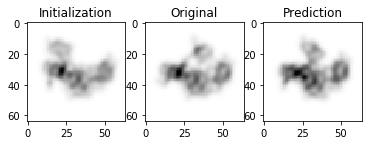

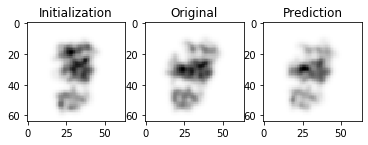

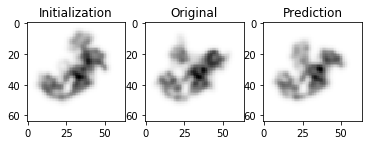

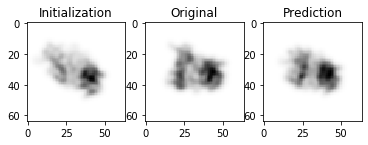

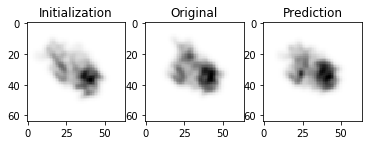

In [9]:
preds = model.pred_images_without_CTF(test_inputs[:5, :-1]).detach()

original_imgs = clean_imgs_no_CTF[test_idx]

for i in range(preds.shape[0]):
    fig, axs = plt.subplots(1, 3)
    
    axs[0].imshow(preds_init[i].transpose(0,1).flip(0,), cmap='Greys')
    axs[0].set_title('Initialization')
    
    
    axs[1].imshow(original_imgs[i].transpose(0,1).flip(0,), cmap='Greys')
    axs[1].set_title('Original')
    
    
    axs[2].imshow(preds[i].transpose(0,1).flip(0,), cmap='Greys')
    axs[2].set_title('Prediction')
    
    name = 'Figures_paper/Fig_3d_predictions/image_pred%i' %i
    #plt.savefig(name)
    plt.show()

#### Predictions of the atomic structures

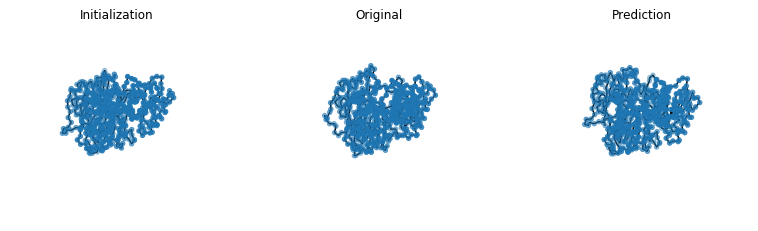

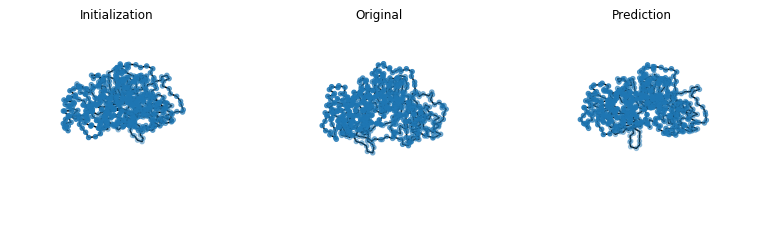

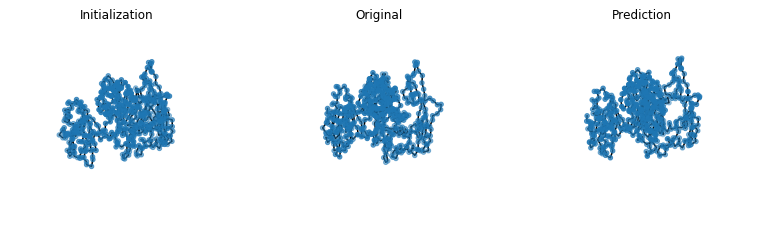

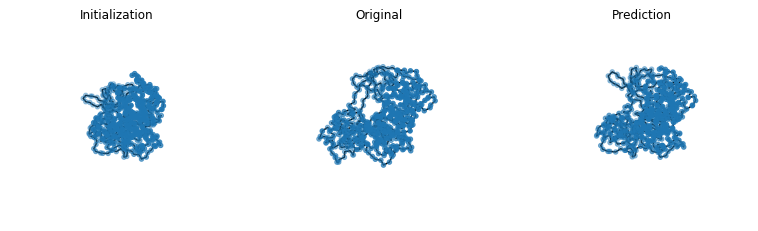

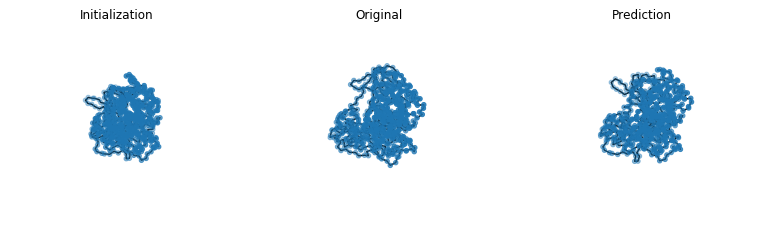

In [10]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm


BB_preds = model.forward_disc_curve(test_inputs[:5]).detach()

BB_original = structure_data.discrete_curves(orientation_diffs_data).detach()[test_idx][:5]


for i in range(5):
    
    fig = plt.figure(figsize=plt.figaspect(0.3))

    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    xdata = np.array(BB_init[i,:,0])
    ydata = np.array(BB_init[i,:,1])
    zdata = np.array(BB_init[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off() 
    ax.set_title('Initialization')
    
    
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    xdata = np.array(BB_original[i,:,0])
    ydata = np.array(BB_original[i,:,1])
    zdata = np.array(BB_original[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off() 
    ax.set_title('Original')
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    xdata = np.array(BB_preds[i,:,0])
    ydata = np.array(BB_preds[i,:,1])
    zdata = np.array(BB_preds[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off() 
    ax.set_title('Prediction')
    
    name = 'Figures_paper/Fig_3d_predictions/atomic_model_pred%i' %i
    #plt.savefig(name)
    plt.show()

In [21]:
orient_good = test_inputs[0,-7:-4].unsqueeze(0)
print(orient_good)

inputs_good = test_inputs.clone()
inputs_good[:, -7:-4] = orient_good

print(inputs_good[:10, -7:-4])

tensor([[1.3723, 3.0278, 3.1267]])
tensor([[1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267],
        [1.3723, 3.0278, 3.1267]])


In [17]:
inputs_good.shape

torch.Size([400, 17])

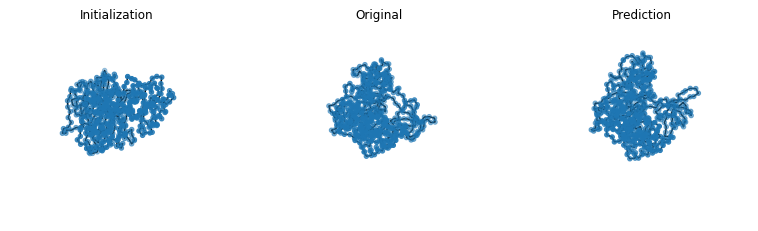

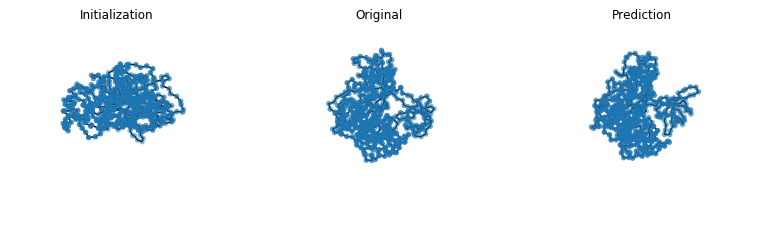

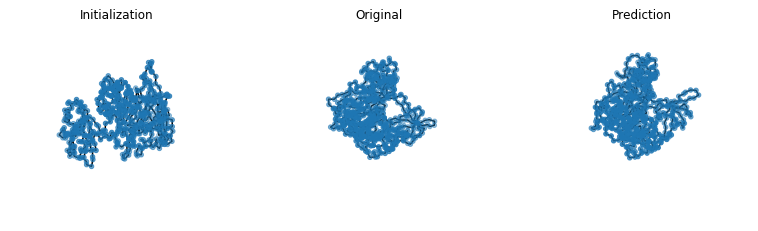

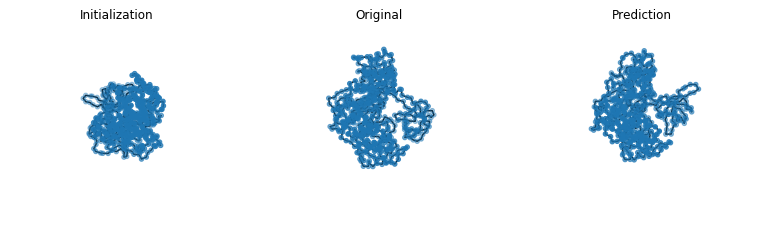

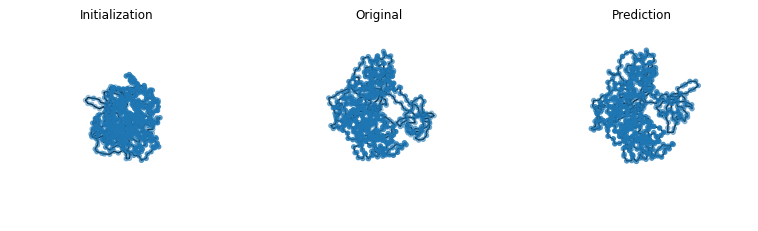

In [59]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm


BB_preds = model.forward_disc_curve(inputs_good[:5]).detach()

good_diffs_data = orient_good - structure_data.orientation
BB_original = structure_data.discrete_curves(good_diffs_data).detach()[test_idx][:5]


for i in range(5):
    
    fig = plt.figure(figsize=plt.figaspect(0.3))

    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    xdata = np.array(BB_init[i,:,0])
    ydata = np.array(BB_init[i,:,1])
    zdata = np.array(BB_init[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off()
    ax.set_title('Initialization')
    
    
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    xdata = np.array(BB_original[i,:,0])
    ydata = np.array(BB_original[i,:,1])
    zdata = np.array(BB_original[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off() 
    ax.view_init(60.,0.)
    ax.set_title('Original')
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    xdata = np.array(BB_preds[i,:,0])
    ydata = np.array(BB_preds[i,:,1])
    zdata = np.array(BB_preds[i,:,2])
    ax.plot3D(xdata, ydata, zdata, 'black')
    ax.scatter(xdata, ydata, zdata)
    ax.set_axis_off() 
    ax.view_init(60.,0.)
    ax.set_title('Prediction')
    
    name = 'Figures_paper/Fig_3d_predictions/atomic_model_pred%i' %i
    #plt.savefig(name)
    plt.show()

torch.Size([4000, 3])